In [1]:
# === SEKCJA 1: IMPORT I KONFIGURACJA ===
import pandas as pd
import numpy as np
import re
import warnings

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from IPython.display import display
import matplotlib.pyplot as plt

# ZMIANA: Ignorowanie ostrzeżeń, które teraz obsługujemy przy wczytywaniu
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

print("Wczytywanie danych...")
# ZMIANA: Dodano `low_memory=False` aby uniknąć DtypeWarning i zapewnić spójność typów
df_main = pd.read_csv('data.csv', sep=',', low_memory=False)
df_ulic = pd.read_csv('Ulic.csv', sep=',')
print("Wszystkie pliki wczytane.")

Wczytywanie danych...
Wszystkie pliki wczytane.


In [2]:
# === SEKCJA 2: PRZYGOTOWANIE DANYCH ===
df_ulic.rename(columns={'Name': 'NAZWA_ULICY'}, inplace=True)
df_ulic.dropna(subset=['SymUl', 'NAZWA_ULICY'], inplace=True)
street_dictionary = pd.Series(df_ulic.NAZWA_ULICY.values, index=df_ulic.SymUl).to_dict()

df_processed = df_main.copy()
df_processed.dropna(subset=['Area', 'Price', 'Description', 'Location', 'StreetNumber'], inplace=True)

def process_location(row):
    location_str, district, street = row['Location'], np.nan, np.nan
    if isinstance(location_str, str):
        parts = [p.strip() for p in location_str.split(',')]
        if len(parts) >= 3 and 'warszawa' in parts[1].lower(): district = parts[2]
    if pd.notna(row['StreetNumber']):
        try:
            street_sym = int(row['StreetNumber'])
            if street_sym in street_dictionary: street = street_dictionary[street_sym]
        except (ValueError, TypeError): pass
    if pd.isna(street) and isinstance(location_str, str) and len(location_str.split(',')) >= 4:
        street = location_str.split(',')[3].strip()
    if isinstance(street, str):
        street = re.sub(r'^(ul\\.|al\\.|pl\\.)\\s*', '', street, flags=re.IGNORECASE).lower()
        if len(street) < 3: street = np.nan
    return pd.Series([district, street])

df_processed[['District', 'Ulica_clean']] = df_processed.apply(process_location, axis=1)
df_processed.dropna(subset=['Ulica_clean', 'District'], inplace=True)

MIN_SAMPLES_PER_STREET = 25
street_counts = df_processed['Ulica_clean'].value_counts()
streets_to_remove = street_counts[street_counts < MIN_SAMPLES_PER_STREET].index
df_model_ready = df_processed[~df_processed['Ulica_clean'].isin(streets_to_remove)].copy()
print(f"Finalny zbiór danych gotowy. Wiersze: {len(df_model_ready)}, Ulice: {df_model_ready['Ulica_clean'].nunique()}")

Finalny zbiór danych gotowy. Wiersze: 52543, Ulice: 682


In [3]:
# === SEKCJA 3: INŻYNIERIA CECH DO SIECI NEURONOWEJ ===
def clean_text(text): return re.sub(r'[^a-ząęółśżźćń ]', '', str(text).lower())
df_model_ready['description_clean'] = df_model_ready['Description'].apply(clean_text)

# ZMIANA: Dodanie nowej funkcji do ekstrakcji kontekstu zabudowy
def get_building_context(description):
    desc = str(description).lower()
    if any(word in desc for word in ['kamienica', 'przedwojenna', 'cegły', 'historyczna']):
        return 'kamienica'
    if any(word in desc for word in ['blok', 'wielka płyta', 'wieżowiec', 'płyt', 'blokowisko']):
        return 'blok'
    if any(word in desc for word in ['apartamentowiec', 'nowe budownictwo', 'nowy budynek', 'inwestycja', 'developerski']):
        return 'apartamentowiec'
    if any(word in desc for word in ['dom', 'szeregowiec', 'bliźniak', 'segment']):
        return 'dom'
    return 'inny'

# ZMIANA: Stworzenie nowej cechy
df_model_ready['BuildingContext'] = df_model_ready['Description'].apply(get_building_context)


MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(df_model_ready['description_clean'])
sequences = tokenizer.texts_to_sequences(df_model_ready['description_clean'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

numeric_features = ['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors']
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
X_numeric = numeric_pipeline.fit_transform(df_model_ready[numeric_features])

# ZMIANA: Dodanie nowej cechy do listy cech kategorycznych
categorical_features = ['District', 'BuildingType', 'BuildingContext']
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
X_categorical = cat_pipeline.fit_transform(df_model_ready[categorical_features])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_model_ready['Ulica_clean'])
num_classes = len(label_encoder.classes_)
print("Dane przygotowane do treningu.")

Dane przygotowane do treningu.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)       │ (None, 200)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 200, 128)          │       2,560,000 │ text_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 256)               │         263,168 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ numeric_input (InputLayer)    │ (None, 5)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ categorical_input             │ (None, 42)                │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 303)               │               0 │ bidirectional[0][0],       │
│                               │                           │                 │ numeric_input[0][0],       │
│                               │                           │                 │ categorical_input[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 512)               │         155,648 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 512)               │           2,048 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 512)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │         131,328 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 256)               │           1,024 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 256)               │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 682)               │         175,274 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,288,490 (12.54 MB)

 Trainable params: 3,286,954 (12.54 MB)

 Non-trainable params: 1,536 (6.00 KB)


Rozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...
Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 167s 990ms/step - accuracy: 0.0742 - loss: 5.6912 - val_accuracy: 0.1285 - val_loss: 5.5066 - learning_rate: 0.0010
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 155s 943ms/step - accuracy: 0.1755 - loss: 3.5590 - val_accuracy: 0.1964 - val_loss: 4.2791 - learning_rate: 0.0010
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 147s 888ms/step - accuracy: 0.2260 - loss: 3.1592 - val_accuracy: 0.2652 - val_loss: 3.2197 - learning_rate: 0.0010
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 144s 873ms/step - accuracy: 0.2791 - loss: 2.8683 - val_accuracy: 0.3143 - val_loss: 2.7976 - learning_rate: 0.0010
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 146s 887ms/step - accuracy: 0.3500 - loss: 2.5430 - val_accuracy: 0.3457 - val_loss: 2.6046 - learning_rate: 0.0010
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 146s 888ms/step - accuracy: 0.4039 - loss: 2.2936 - val_accuracy: 0.3832 - val_loss: 2.4601 - learning_rate: 

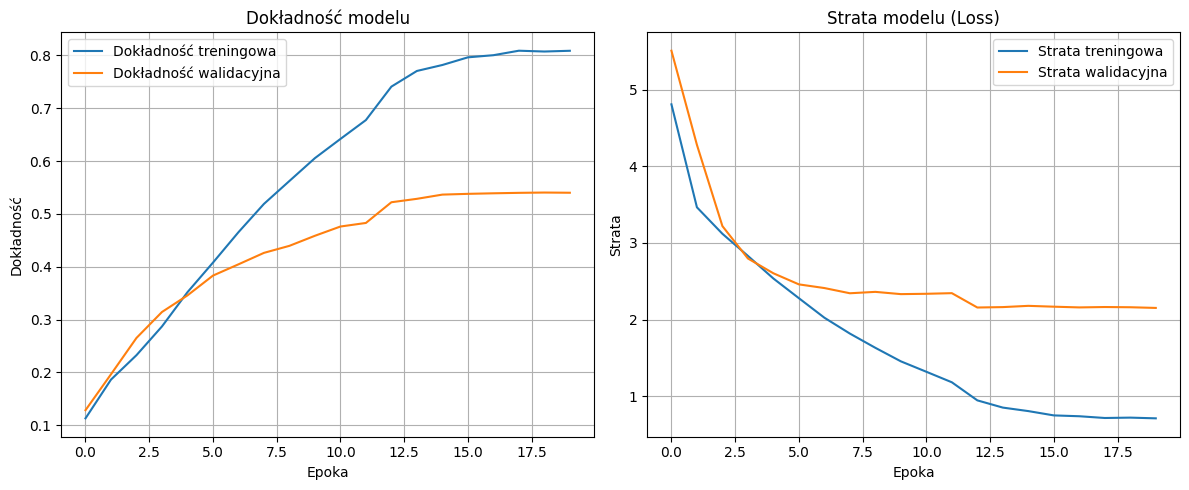

In [4]:
# === SEKCJA 4: BUDOWA I TRENING - WERSJA Z BIDIRECTIONAL LSTM I INŻYNIERIĄ CECH ===

# Definicja architektury z Bidirectional LSTM
input_text = Input(shape=(MAX_LEN,), name='text_input')
input_numeric = Input(shape=(X_numeric.shape[1],), name='numeric_input')
input_categorical = Input(shape=(X_categorical.shape[1],), name='categorical_input')

embedding_layer = Embedding(input_dim=MAX_WORDS, output_dim=128)(input_text)
# ZMIANA: Zastosowanie Bidirectional LSTM
lstm_layer = Bidirectional(LSTM(128, dropout=0.2))(embedding_layer)
concatenated = Concatenate()([lstm_layer, input_numeric, input_categorical])

# Warstwy gęste jak w oryginalnej, dobrze działającej wersji
x = Dense(512, activation='relu')(concatenated)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_text, input_numeric, input_categorical], outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Podział i trening
X_train_text, X_val_text, X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_text, X_numeric, X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

print("\nRozpoczynam trening sieci neuronowej (wersja z Bidirectional LSTM)...")
history = model.fit(
    [X_train_text, X_train_num, X_train_cat], y_train,
    validation_data=([X_val_text, X_val_num, X_val_cat], y_val),
    epochs=20,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr]
)

# Zapis modelu
model.save('street_predictor_final_v4.keras')
print("\nModel został wytrenowany i zapisany jako 'street_predictor_final_v4.keras'.")

# Wizualizacja
print("\nGenerowanie wykresów uczenia...")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata modelu (Loss)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# === SEKCJA 5: PREDYKCJA NA CAŁEJ BAZIE I WZBOGACENIE DANYCH ===

print("Przygotowywanie całego zbioru danych do predykcji...")

# Stworzenie kopii oryginalnego zbioru danych
df_predict_base = df_main.copy()

# 1. Stosowanie tych samych transformacji, co na zbiorze treningowym
df_predict_base[['District', 'Ulica_clean']] = df_predict_base.apply(process_location, axis=1)
df_predict_base['description_clean'] = df_predict_base['Description'].apply(clean_text)
# ZMIANA: Dodanie nowej cechy także do zbioru predykcyjnego
df_predict_base['BuildingContext'] = df_predict_base['Description'].apply(get_building_context)


# Wypełnienie braków w danych, które mogą powodować błędy w pipeline'ach
df_predict_base['description_clean'].fillna('brak opisu', inplace=True)
for col in numeric_features:
    df_predict_base[col].fillna(0, inplace=True)
for col in categorical_features:
    df_predict_base[col].fillna('missing', inplace=True)

# 2. Transformacja danych przy użyciu WYTRENOWANYCH pipeline'ów i tokenizera
sequences_pred = tokenizer.texts_to_sequences(df_predict_base['description_clean'])
X_text_full = pad_sequences(sequences_pred, maxlen=MAX_LEN)
X_numeric_full = numeric_pipeline.transform(df_predict_base[numeric_features])
X_categorical_full = cat_pipeline.transform(df_predict_base[categorical_features])

print("Generowanie predykcji dla całego zbioru danych...")
# 3. Predykcja
predictions_proba = model.predict([X_text_full, X_numeric_full, X_categorical_full])
predicted_labels_encoded = np.argmax(predictions_proba, axis=1)
predicted_street_names = label_encoder.inverse_transform(predicted_labels_encoded)
predicted_probabilities = np.max(predictions_proba, axis=1)

# 4. Dodanie wyników do DataFrame
df_predict_base['Predicted_Ulica'] = predicted_street_names
df_predict_base['Predicted_Ulica_Prob'] = predicted_probabilities

print("Predykcja zakończona. Dane zostały wzbogacone.")

Przygotowywanie całego zbioru danych do predykcji...
Generowanie predykcji dla całego zbioru danych...
6133/6133 ━━━━━━━━━━━━━━━━━━━━ 310s 51ms/step
Predykcja zakończona. Dane zostały wzbogacone.


In [6]:
# === SEKCJA 6: WERYFIKACJA I KOREKTA PREDYKCJI ===

print("Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...")
# Używamy df_model_ready, bo zawiera tylko te ulice i dzielnice, na których model był uczony
street_to_district_map = df_model_ready.drop_duplicates(subset='Ulica_clean').set_index('Ulica_clean')['District'].to_dict()

# Dodajemy mapowanie jako nową kolumnę w zbiorze z predykcjami
df_predict_base['Predicted_Ulica_District'] = df_predict_base['Predicted_Ulica'].map(street_to_district_map)

print("Weryfikacja spójności predykcji...")

# Funkcja do weryfikacji spójności
def verify_prediction(row):
    # Sprawdzamy tylko dla wierszy, gdzie mamy oryginalną dzielnicę (nie 'missing' lub NaN)
    if pd.notna(row['District']) and row['District'] != 'missing':
        if row['District'] == row['Predicted_Ulica_District']:
            return 'Zgodna'
        else:
            return 'Niezgodna'
    return 'Brak danych do weryfikacji'

df_predict_base['Prediction_Status'] = df_predict_base.apply(verify_prediction, axis=1)

# Wyświetlanie statystyk spójności
print("\nStatystyki spójności predykcji:")
print(df_predict_base['Prediction_Status'].value_counts())

# Wyświetlanie przykładów niezgodnych predykcji (jak ta, którą znalazłeś)
print("\nPrzykładowe 10 losowych niezgodnych predykcji:")
display_cols_check = ['SaleId', 'Location', 'District', 'Predicted_Ulica', 'Predicted_Ulica_District', 'Predicted_Ulica_Prob', 'Description']
display(df_predict_base[df_predict_base['Prediction_Status'] == 'Niezgodna'][display_cols_check].sample(10, random_state=1))

# Wyświetlanie przykładowych wyników końcowych
print("\nPrzykładowe 25 losowych wierszy z uzupełnionymi danymi:")
display_cols = ['SaleId', 'Location', 'District', 'Predicted_Ulica', 'Predicted_Ulica_District', 'Prediction_Status', 'Predicted_Ulica_Prob', 'Price', 'Area']
display(df_predict_base[display_cols].sample(25, random_state=42))

# Zapis do pliku CSV
output_filename_verified = 'data_with_predicted_and_verified_streets.csv'
df_predict_base.to_csv(output_filename_verified, index=False, sep=',')
print(f"\nFinalny DataFrame ({len(df_predict_base)} wierszy) zapisano do pliku: {output_filename_verified}")

Tworzenie mapy ulica -> dzielnica na podstawie danych treningowych...
Weryfikacja spójności predykcji...

Statystyki spójności predykcji:
Prediction_Status
Zgodna                        120355
Brak danych do weryfikacji     66341
Niezgodna                       9544
Name: count, dtype: int64

Przykładowe 10 losowych niezgodnych predykcji:


,SaleId,Location,District,Predicted_Ulica,Predicted_Ulica_District,Predicted_Ulica_Prob,Description
179016,4238523,"Mazowieckie, Warszawa, Śródmieście, Śródmieści...",Śródmieście,aleje jerozolimskie,Włochy,0.999900,Na sprzedaż fantastyczne mieszkanie przy samym...
193472,4395100,"Mazowieckie, Warszawa, Wola, Mirów, Ul. Icchok...",Wola,icchoka lejba pereca,Śródmieście,0.247209,Mieszkanie do kapitalnego remontu. Do renowacj...
79741,2831191,"Mazowieckie, Warszawa, Ursynów, Ul. Przy Bażan...",Ursynów,bokserska,Mokotów,0.443279,Na sprzedaż mieszkanie 2-pokojowe na Ursynowie...
177337,4219362,"Mazowieckie, Warszawa, Mokotów, Wierzbno, Ul. ...",Mokotów,czerniakowska,Śródmieście,0.580450,Opis nieruchomości: Przedstawiam Państwu wyjąt...
140593,3669944,"Mazowieckie, Warszawa, Włochy",Włochy,1 sierpnia,Ochota,0.742343,Oferta aktualna - możliwość umówienia bezpiecz...
158109,3940643,"Mazowieckie, Warszawa, Żoliborz",Żoliborz,władysława broniewskiego,Bielany,0.903726,Do sprzedaży komfortowe trzypokojowe mieszkani...
112738,3239779,"Mazowieckie, Warszawa, Mokotów",Mokotów,czerniakowska,Śródmieście,0.571480,"Mieszkanie, Warszawa, Mokotów, 59 m² Ogłoszeni..."
56019,2189667,"Mazowieckie, Warszawa, Śródmieście, Ul. Pańska",Śródmieście,pańska,Wola,0.917890,Ponoć w nieruchomości najważniejsze są trzy rz...
41409,1716451,"Mazowieckie, Warszawa, Wola",Wola,górczewska,Bemowo,0.624683,Oferta dodana za pomocą Multiportalu BeBroker ...
79182,2825281,"Mazowieckie, Warszawa, Śródmieście, Ul. Chmielna",Śródmieście,chmielna,Wola,0.957257,OFERTA BEZPOŚREDNIA Szukasz mieszkania dla sie...



Przykładowe 25 losowych wierszy z uzupełnionymi danymi:


,SaleId,Location,District,Predicted_Ulica,Predicted_Ulica_District,Prediction_Status,Predicted_Ulica_Prob,Price,Area
117971,3306651,"Mazowieckie, Warszawa, Mokotów, Ul. Polska",Mokotów,polska,Mokotów,Zgodna,0.997750,992250.0,55.90
105430,3136257,"Mazowieckie, Warszawa, Białołęka, Ul. Winorośli",Białołęka,mochtyńska,Białołęka,Zgodna,0.514671,0.0,50.00
130903,3506482,"Mazowieckie, Warszawa, Mokotów, Ksawerów",Mokotów,wołoska,Mokotów,Zgodna,0.761004,1904000.0,83.95
180140,4249856,"Mazowieckie, Grodziski, Grodzisk Mazowiecki",missing,szamoty,Ursus,Brak danych do weryfikacji,0.109488,699000.0,55.00
73766,2760208,"Mazowieckie, Warszawa, Bemowo, Ul. Strońska",Bemowo,wrocławska,Bemowo,Zgodna,0.231499,850000.0,66.70
85493,2889192,"Mazowieckie, Radomski, Zakrzew, Bielicha",missing,szklanych domów,Praga-południe,Brak danych do weryfikacji,0.256302,299000.0,67.50
19147,913358,"Mazowieckie, Warszawa, Ursus, Ul. Przy Forcie",Ursus,gen. kazimierza sosnkowskiego,Ursus,Zgodna,0.225726,0.0,49.74
139381,3652415,"Mazowieckie, Warszawa, Praga-południe, Ul. Pol...",Praga-południe,motorowa,Praga-południe,Zgodna,0.449315,865000.0,51.10
20811,954853,"Mazowieckie, Warszawa, Ursus, Ul. Szamoty",Ursus,herbu oksza,Ursus,Zgodna,0.704030,0.0,54.76
143413,3713496,"Mazowieckie, Legionowski, Legionowo, Ul. Husarska",missing,zagłoby,Ursus,Brak danych do weryfikacji,0.097769,525000.0,54.00



Finalny DataFrame (196240 wierszy) zapisano do pliku: data_with_predicted_and_verified_streets.csv
